In [6]:
!pip install qiskit
!pip install cirq

     |████████████████████████████████| 1.4MB 8.9MB/s 
     |████████████████████████████████| 1.2MB 30.1MB/s 
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


In [1]:
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit import Aer
from qiskit.compiler import transpile

In [2]:
import numpy as np
from math import sin, cos, atan2
import matplotlib.pyplot as plt
from numpy.linalg import norm,svd

In [0]:
def state_prep(ckt,A,q):
    if q==1:
        ckt.u3(2*atan2(A[1],A[0]),0,0,0)
        return ckt
    
    n=q-q//2 #n>=m
    m=q//2
    A=np.reshape(A,(2**m,2**n))
    A=np.transpose(A)
    
    U,S,V=np.linalg.svd(A)
    ckt=state_prep(ckt,S,q//2)
    
    for i in range(m):
        ckt.cx(i,i+n)
    if q%2==1:
        ckt.cx(q//2,q-1)
    ckt.barrier()
    
    ckt.unitary(Operator(U), list(range(n)))
    ckt.unitary(Operator(np.transpose(V)), list(range(n,q)))
    ckt.barrier()
    print(q,"Q   done")
    return ckt

## Cosine-Sine Decomposition Qiskit

In [0]:
def direct_sum(A,B):
    n=np.shape(A)[0]
    m=np.shape(B)[0]
    res=np.zeros((n+m,n+m))
    res[:n,:n]=A
    res[n:,n:]=B
    return res

def genY(C,S):
    n=np.shape(C)[0]
    m=np.shape(S)[0]
    res=np.zeros((n+m,n+m))
    res[:n,:n]=C
    res[:n,n:]=-S
    res[n:,:n]=S
    res[n:,n:]=C
    return res

In [0]:
def CSD(U,q):
    n=2**q
    A=U[:n//2,:n//2]
    B=U[n//2:,n//2:]
    U1,C,V1=np.linalg.svd(A)
    U2,C,V2=np.linalg.svd(B)
    V1=V1.T
    V2=V2.T

    S=U2.T@U[n//2:,:n//2]@V1      
    #S=-U1.T@U[:n//2,n//2:]@V2 
    #S=np.sin(np.arccos(C))#(1-C**2)**0.5   #Doesn't take care of the sign of Sine

    C=np.diag(C)

    return U1,U2,genY(C,S),V1.T,V2.T

In [0]:
q=2
n=2**q

A=np.random.rand(n,n)
U,S,V=np.linalg.svd(A)

ckt=QuantumCircuit(2,1)
ckt.unitary(U,[0,1])

ckt=transpile(ckt,basis_gates=['u3','cx'],seed_transpiler=0)

ckt.draw(output='mpl')

In [0]:
ckt=QuantumCircuit(2)
ckt.crz(0.1,0,1)
ckt=transpile(ckt,basis_gates=['u3','cx'],seed_transpiler=0)
ckt.draw(output='mpl')

## Two-Qubit Decomposition using Cirq

In [32]:
import cirq
from scipy.stats import unitary_group

def two_qubit_unitary_decomposition(U):
  M=np.array([[1,0,0,1j],[0,1j,1,0],[0,1j,-1,0],[1,0,0,1j]])
  lambd=np.array([[1,1,-1,1],[1,1,1,-1],[1,-1,-1,-1],[1,-1,1,1]])
  U0=(M.conj().T)@U@M
  UR=(U0+U0.conj())/2
  UL=(U0-U0.conj())/2j

  V1,C,X=np.linalg.svd(UR)
  X=X.T
  #Incomplete

U=unitary_group.rvs(4)
two_qubit_unitary_decomposition(U)

[[ 0.35+0.j -0.16+0.j  0.85+0.j -0.36+0.j]
 [-0.25+0.j -0.07+0.j -0.3 +0.j -0.92+0.j]
 [ 0.21+0.j  0.96+0.j  0.03+0.j -0.15+0.j]
 [-0.88+0.j  0.19+0.j  0.44+0.j  0.08+0.j]]
[[-0.74+0.j -0.28+0.j  0.59+0.j -0.16+0.j]
 [ 0.39+0.j -0.71+0.j  0.  +0.j -0.59+0.j]
 [-0.28+0.j -0.62+0.j -0.49+0.j  0.55+0.j]
 [-0.47+0.j  0.22+0.j -0.63+0.j -0.57+0.j]]


## Circuit Decompostion on Qiskit

OrderedDict([('u3', 4764), ('cx', 4474)])


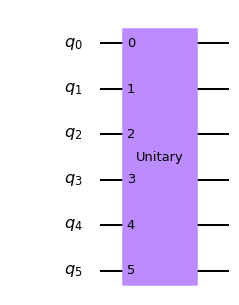

In [3]:
q=6
A=np.random.rand(2**q,2**q)

U,S,V=np.linalg.svd(A)

qiskit_ckt=QuantumCircuit(q)
qiskit_ckt.unitary(Operator(U), list(range(q)))

print(transpile(qiskit_ckt,basis_gates=['cx','u3']).count_ops())
qiskit_ckt.draw(output='mpl')

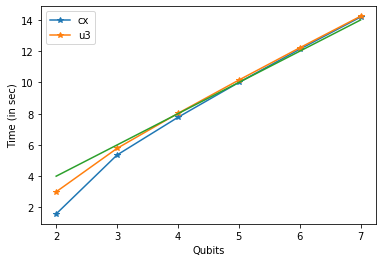

In [4]:
T=np.array([[2,3,8],[3,41,55],[4,218,260],[5,1025,1139],[6,4474,4764],[7,18653,19359]])

plt.plot(T[:,0],np.log2(T[:,1]),marker='*',label='cx')
plt.plot(T[:,0],np.log2(T[:,2]),marker='*',label='u3')
plt.plot(T[:,0],2*T[:,0])
plt.xlabel('Qubits')
plt.ylabel('Time (in sec)')
plt.legend()
plt.show()